In [0]:
import torchvision
import torch
import numpy as np
import os

BASE_PATH = '/content/Clothes/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import shutil
shutil.copytree('/content/drive/My Drive/Clothes/', '/content/Clothes/')

'/content/Clothes/'

In [0]:
import zipfile
with zipfile.ZipFile('/content/Clothes/img.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Clothes/')

# Dataset loading

In [0]:
cats_file = open(BASE_PATH + 'Anno/list_category_cloth.txt', 'r').readlines()
cats_img_file = open(BASE_PATH + 'Anno/list_category_img.txt', 'r').readlines()

In [0]:
path_to_idx = {}
idx_to_path = {}

cats_img_file = [list(filter(None, x.strip().split(' '))) for x in cats_img_file[2:]]

for i, img in enumerate(cats_img_file):
    path = img[0]
    idx_to_path[i] = path
    path_to_idx[path] = i

N_SAMPLES = len(idx_to_path)

In [0]:
categories = []

for ln in cats_file[2:]:
    cur = list(filter(None, ln[:-1].split(' ')))
    categories.append(cur[0])

    
cat_target = np.zeros((len(idx_to_path), len(categories)), dtype=np.uint8)
cat_list = {}

for img in cats_img_file:
    cur_cat = int(img[1]) - 1

    cat_target[path_to_idx[img[0]]][cur_cat] = 1
    if cur_cat in cat_list:
        cat_list[cur_cat].append(path_to_idx[img[0]])
    else:
        cat_list[cur_cat] = [path_to_idx[img[0]]]

In [0]:
train_idxs = []
val_idxs   = []

split_file = open(BASE_PATH + 'Eval/list_eval_partition.txt', 'r').readlines()

for ln in split_file[2:]:
    cur = list(filter(None, ln[:-1].split(' ')))
    cur_type = cur[1]
    if cur_type == 'train':
        train_idxs.append(path_to_idx[cur[0]])
    elif cur_type == 'val':
        val_idxs.append(path_to_idx[cur[0]])
        
train_idxs = np.array(train_idxs)
val_idxs = np.array(val_idxs)

# Data loading

In [0]:
from skimage.transform import rescale
from PIL import Image

TARGET_SIZE = (224, 224)

def load_img(path):
    result = np.ones((TARGET_SIZE[0], TARGET_SIZE[1], 3), dtype=np.uint8) * 255
    img = Image.open(path)
    img.thumbnail(TARGET_SIZE)
    offset = (np.array(TARGET_SIZE) - np.array(img.size)) // 2
    result[offset[1]: offset[1] + img.size[1], offset[0]: offset[0] + img.size[0]] = np.array(img)
    return result


In [0]:
def batch_generator(batch_size=32, dataset='train', shuffle=True):
    if dataset == 'train':
        idxs = train_idxs 
    else:
        idxs = val_idxs
        
    perm = np.random.permutation(idxs) if shuffle else np.arange(len(idxs))
    start_idx = 0
    while True:
        if start_idx + batch_size > len(idxs):
            perm = np.random.permutation(idxs) if shuffle else np.arange(len(idxs))
            start_idx = 0
        imgs = [load_img(BASE_PATH + idx_to_path[perm[start_idx + i]]) for i in range(batch_size)]
        imgs = np.stack(imgs) / 256.0 - 0.5
        imgs = torch.tensor(imgs, dtype=torch.float32, device='cuda:0').permute(0, 3, 1, 2).contiguous()
        
        cur_idxs = perm[start_idx: start_idx + batch_size]
        target = torch.tensor(cat_target[cur_idxs].argmax(1), dtype=torch.int64, device='cuda:0').contiguous()
        start_idx += batch_size
        yield imgs, target

# Architecture

In [11]:
model = torchvision.models.resnext101_32x8d(pretrained=True)
model.fc = torch.nn.Linear(in_features=2048, out_features=1024, bias=True)
model = torch.nn.Sequential(
    model,
    torch.nn.Linear(in_features=1024, out_features=50, bias=True)
).cuda()

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [0]:
for j, ch in enumerate(model.children()):
    if j == 0:
        for i, layer in enumerate(ch.children()):
            if i < 9:
                for param in layer.parameters():
                    param.requires_grad = False
            if i == 9:
                for param in layer.parameters():
                    param.requires_grad = True
                
    else:
        for param in ch.parameters():
            param.requires_grad = True

In [0]:
from torchsummary import summary
summary(model, (3, 224, 224))

In [0]:
import time
import copy

def train_model(model, criterion, optimizer, num_epochs=3, batch_size=12):
    since = time.time()

    history = {}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    dataloaders = {
        'train' : batch_generator(batch_size=batch_size, dataset='train'),
        'val' : batch_generator(batch_size=batch_size, dataset='val')
    }

    for epoch in range(num_epochs):
        history[epoch] = {}
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_top_3 = 0.0
            running_top_5 = 0.0

            # Iterate over data.
            N_STEPS = len(train_idxs if phase == 'train' else val_idxs) // batch_size
            N_STEPS = N_STEPS // 4
            total_imgs = 0
            s = time.time()
            for step in range(N_STEPS):
                inputs, labels = next(dataloaders[phase])
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    pred_order = torch.argsort(outputs, dim=1, descending=True)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                cur_corrects = torch.sum(preds == labels.data)
                running_corrects += cur_corrects
                
                cur_top_3 = (pred_order[:, :3] == labels.view(-1, 1)).sum()
                cur_top_5 = (pred_order[:, :5] == labels.view(-1, 1)).sum()
                running_top_3 += cur_top_3
                running_top_5 += cur_top_5
                
                total_imgs += batch_size
                t = time.time()
                print('Step: %d/%d (%.2f ms per step). Loss: %.4f. Batch-accuracy: %.2f%%. Batch-top-3: %.2f%%. Batch-top-5: %.2f%% ' % (
                    step, N_STEPS, (t-s)*1000.0 / (step + 1), 
                    running_loss / total_imgs, 
                    cur_corrects * 100.0 / batch_size,
                    cur_top_3 * 100.0 / batch_size,
                    cur_top_5 * 100.0 / batch_size
                ))
            
            cur_idxs = train_idxs if phase == 'train' else val_idxs
            epoch_loss = running_loss / total_imgs
            epoch_acc = running_corrects.double() / total_imgs
            epoch_top3 = running_top_3.double() / total_imgs
            epoch_top5 = running_top_5.double() / total_imgs
            
            history[epoch][phase] = {
                'loss' : epoch_loss,
                'accuracy' : epoch_acc,
                'top3-acc' : epoch_top3,
                'top5-acc' : epoch_top5
            }
            
            print()
            print('Epoch %d| %s| Loss: %.4f. Acc: %.4f' % (epoch, phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model, f'D:\Programming\CourseWork_3\Clothes\\model{mod}_{epoch}.pth')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [0]:
loss = torch.nn.CrossEntropyLoss()

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

result = train_model(model, loss, optimizer_ft, batch_size=32, num_epochs=4)

In [0]:
model = result[0]
torch.save(model.state_dict(), f"/content/drive/My Drive/Clothes/model_last.pt")

In [0]:
import tqdm
gen = batch_generator(batch_size=32, dataset='val')

N_STEPS = 1250

accuracy = 0.0
top3_acc = 0.0
top5_acc = 0.0

model.eval()
with torch.set_grad_enabled(False):
    for i in tqdm.tqdm(range(N_STEPS)):
        imgs, labels = next(gen)
        outs = model(imgs)
        pred_order = torch.argsort(outs, dim=1, descending=True)

        accuracy += (pred_order[:, 0] == labels).sum()
        top3_acc += (pred_order[:, :3] == labels.view(-1, 1)).sum()
        top5_acc += (pred_order[:, :5] == labels.view(-1, 1)).sum()

100%|██████████| 1250/1250 [05:25<00:00,  3.84it/s]


In [0]:
total_imgs = N_STEPS * 32
print('Accuracy: %.3f%%. Top3-accuracy: %.3f%%. Top5-accuracy: %.3f%% ' % (
    float(accuracy) * 100.0 / total_imgs,
    float(top3_acc) * 100.0 / total_imgs,
    float(top5_acc) * 100.0 / total_imgs), 
)

Accuracy: 55.315%. Top3-accuracy: 78.270%. Top5-accuracy: 87.220% 


### Fine tuning of convolutional layers

In [0]:
torch.cuda.empty_cache()

<All keys matched successfully>

In [0]:
model = torchvision.models.resnext101_32x8d(pretrained=False)
model.fc = torch.nn.Linear(in_features=2048, out_features=1024, bias=True)
model = torch.nn.Sequential(
    model,
    torch.nn.Linear(in_features=1024, out_features=50, bias=True)
).cuda()
model.load_state_dict(torch.load("/content/drive/My Drive/Clothes/model_last.pt"))

In [0]:
for param in model.parameters():
    param.requires_grad = True

In [0]:
from torchsummary import summary
summary(model, (3, 224, 224))

In [0]:
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = True
loss = torch.nn.CrossEntropyLoss()

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

result = train_model(model, loss, optimizer_ft, batch_size=32, num_epochs=4)

In [0]:
model = result[0]
torch.save(model.state_dict(), f"/content/drive/My Drive/Clothes/model_all.pt")

In [0]:
import tqdm
gen = batch_generator(batch_size=32, dataset='val', shuffle=False)

N_STEPS = 1250

accuracy = 0.0
top3_acc = 0.0
top5_acc = 0.0

model.eval()
preds_lst = []
labels_lst = []
with torch.set_grad_enabled(False):
    for i in tqdm.tqdm(range(N_STEPS)):
        imgs, labels = next(gen)
        labels_lst.append(labels.detach().cpu().numpy())
        outs = model(imgs)
        preds_lst.append(outs.argmax(dim=1).detach().cpu().numpy())
        pred_order = torch.argsort(outs, dim=1, descending=True)

        accuracy += (pred_order[:, 0] == labels).sum()
        top3_acc += (pred_order[:, :3] == labels.view(-1, 1)).sum()
        top5_acc += (pred_order[:, :5] == labels.view(-1, 1)).sum()

100%|██████████| 1250/1250 [07:14<00:00,  2.88it/s]


In [0]:
torch.save(model.state_dict(), 'deepfashion_cat_ep8.torch')

In [0]:
total_imgs = N_STEPS * 32
print('Accuracy: %.3f%%. Top3-accuracy: %.3f%%. Top5-accuracy: %.3f%% ' % (
    float(accuracy) * 100.0 / total_imgs,
    float(top3_acc) * 100.0 / total_imgs,
    float(top5_acc) * 100.0 / total_imgs)
)

Accuracy: 63.642%. Top3-accuracy: 86.310%. Top5-accuracy: 93.965% 


## Visual evaluation

In [0]:
torch.cuda.empty_cache()

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
model = torchvision.models.resnext101_32x8d(pretrained=False)
model.fc = torch.nn.Linear(in_features=2048, out_features=1024, bias=True)
model = torch.nn.Sequential(
    model,
    torch.nn.Linear(in_features=1024, out_features=50, bias=True)
).cuda()
model.load_state_dict(torch.load("/content/drive/My Drive/Clothes/model_all.pt"))

1) Jumpsuit 83.68% 
2) Romper 7.33% 
3) Dress 3.12% 
4) Jeans 0.79% 
5) Top 0.75% 


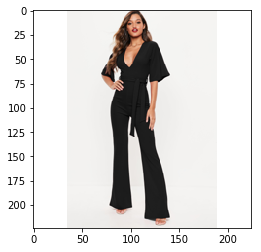

In [0]:
img = load_img('tmp.jpg')
plt.imshow(img)
img = torch.tensor(img, dtype=torch.float32, device='cuda:0').reshape(1, 224, 224, 3).permute(0, 3, 1, 2)
img = img / 256.0 - 0.5

sm = torch.nn.Softmax(dim=1)
probs = sm(model(img))
probs, idxs = probs.sort(descending=True)
probs = probs.detach().cpu().numpy()[0]
idxs = idxs.detach().cpu().numpy()[0]

for i in range(5):
    print('%d) %s %.2f%% ' % (i + 1, categories[idxs[i]], probs[i] * 100.0))